# Building and training a very simple RNN from scratch

Sources:
 - [Show, Attend and Tell Paper](https://arxiv.org/pdf/1502.03044.pdf)
 - [Andrej Karapthy's Dissertation](https://cs.stanford.edu/people/karpathy/main.pdf) (See section 4.2)
 - [TF Tutorial](https://www.tensorflow.org/tutorials/text/image_captioning)

## Load Training Dataset:

We will use a sample of 30k image caption pairs as training data, leaving a large random sample of untouched 10k image caption pairs for testing

In [4]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import os
from tqdm import tqdm
import time
#initialization code required to make tensorflow work on my systemabs
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
print(tf.__version__)

2.4.1


In [5]:
data_df = pd.read_csv()

In [6]:
data_df

,global_index,caption,link,objects,mid,object_confidences,image_path,size,height,width,aspect_ratio,num_obj,nltk_sent_polarity,nltk_sent,nltk_sent_pos_neg,nltk_sent_pos_neg_conf,hf_sent,hf_sent_class,hf_sent_conf
0,552309,drum and drumsticks pattern repeat seamless in...,https://thumb7.shutterstock.com/display_pic_wi...,"font,line,black-and-white,pattern,design,illus...","/m/03gq5hm,/m/03scnj,/m/01g6gs,/m/0hwky,/m/02c...","0.920914888381958,0.8690993189811707,0.7811979...",data\30k_sample\images\552309.png,"(450, 470)",470,450,0.957447,11,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neu,pos,0.000,"[{'label': 'NEGATIVE', 'score': 0.921588003635...",NEGATIVE,0.921588
1,225955,abstract image with bright triangles on a whit...,https://thumb7.shutterstock.com/display_pic_wi...,"orange,yellow,text,line,graphic design,font,ma...","/m/0jc_p,/m/088fh,/m/07s6nbt,/m/03scnj,/m/03c3...","0.952930212020874,0.9477446675300598,0.9396671...",data\30k_sample\images\225955.png,"(450, 470)",470,450,0.957447,10,"{'neg': 0.0, 'neu': 0.707, 'pos': 0.293, 'comp...",neu,pos,0.293,"[{'label': 'POSITIVE', 'score': 0.990414261817...",POSITIVE,0.990414
2,1415488,digital art selected for the #,http://33.media.tumblr.com/22eb1f56c2492784192...,"poster,movie,comedy,advertising,album cover,co...","/m/01n5jq,/m/02vxn,/g/12gh3rj_8,/m/011s0,/m/06...","0.9679052233695984,0.9337120056152344,0.663505...",data\30k_sample\images\1415488.png,"(1000, 1415)",1415,1000,0.706714,8,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neu,pos,0.000,"[{'label': 'POSITIVE', 'score': 0.992724180221...",POSITIVE,0.992724
3,1158867,girl at the computer prints royalty free stock...,https://static9.depositphotos.com/1000372/1077...,"silhouette,cartoon,sitting,desk,illustration,t...","/m/03thgk,/m/0215n,/m/015c4z,/m/01y9k5,/m/01kr...","0.9242428541183472,0.9118318557739258,0.881848...",data\30k_sample\images\1158867.png,"(600, 600)",600,600,1.000000,12,"{'neg': 0.0, 'neu': 0.708, 'pos': 0.292, 'comp...",neu,pos,0.292,"[{'label': 'NEGATIVE', 'score': 0.995157957077...",NEGATIVE,0.995158
4,218113,"roadside home and tree , along the road .",https://dfkotz.files.wordpress.com/2016/10/201...,"tree,leaf,sky,nature,autumn,natural landscape,...","/m/07j7r,/m/09t49,/m/01bqvp,/m/05h0n,/m/0134l,...","0.9876532554626465,0.9692031741142273,0.964882...",data\30k_sample\images\218113.png,"(667, 1000)",1000,667,0.667000,15,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neu,pos,0.000,"[{'label': 'POSITIVE', 'score': 0.988865137100...",POSITIVE,0.988865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29923,471205,the house of deity : mosaics,https://media-cdn.tripadvisor.com/media/photo-...,"art,banknote,paper,mosaic,history,ancient hist...","/m/0jjw,/m/01dl3j,/m/0641k,/m/0gmk4,/m/03g3w,/...","0.8178251385688782,0.7246490716934204,0.702492...",data\30k_sample\images\471205.png,"(550, 412)",412,550,1.334951,8,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neu,pos,0.000,"[{'label': 'POSITIVE', 'score': 0.989008367061...",POSITIVE,0.989008
29924,593566,actor at a fashion event,https://media.gettyimages.com/photos/monica-be...,"stage,performance,fashion,singer,event,fashion...","/m/04_5hy,/m/01gq53,/m/032tl,/m/09l65,/m/081pk...","0.9543529152870178,0.9349019527435303,0.909356...",data\30k_sample\images\593566.png,"(468, 612)",612,468,0.764706,15,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neu,pos,0.000,"[{'label': 'POSITIVE', 'score': 0.960797250270...",POSITIVE,0.960797
29925,1098702,man conducted the service for person,https://i2.wp.com/i.dailymail.co.uk/i/pix/2015...,"rite,religious institute,bishop,ceremony,event...","/m/01rhcg,/m/0h64tv6,/m/027k49j,/m/016c4t,/m/0...","0.9725196361541748,0.9299913644790649,0.912284...",data\30k_sample\images\1098702.png,"(634, 500)",500,634,1.268000,15,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neu,pos,0.000,"[{'label': 'POSITIVE', 'score': 0.997708082199...",POSITIVE,0.997708
29926,790196,supermodel i

### Preprocess and tokenize captions

In [7]:
#preprocess captions tpo include start and end tokens
data_df['captions_processed'] = data_df['caption'].apply(lambda x: '<start> ' + x + ' <end>')

In [8]:

tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(data_df['captions_processed'])

In [9]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [10]:
data_df['captions_processed']

0        <start> drum and drumsticks pattern repeat sea...
1        <start> abstract image with bright triangles o...
2             <start> digital art selected for the # <end>
3        <start> girl at the computer prints royalty fr...
4        <start> roadside home and tree , along the roa...
                               ...                        
29923           <start> the house of deity : mosaics <end>
29924               <start> actor at a fashion event <end>
29925    <start> man conducted the service for person <...
29926    <start> supermodel is photographed at a portra...
29927    <start> character dressed in the traditional w...
Name: captions_processed, Length: 29928, dtype: object

In [11]:
data_df['captions_tokenized'] = tokenizer.texts_to_sequences(data_df['captions_processed'])

In [12]:
data_df['captions_tokenized'] 

0        [2, 5362, 9, 6457, 85, 1497, 124, 7, 47, 167, ...
1            [2, 186, 123, 10, 335, 1918, 8, 5, 18, 17, 3]
2                              [2, 381, 92, 574, 12, 4, 3]
3         [2, 74, 14, 4, 542, 2405, 565, 237, 187, 874, 3]
4                     [2, 6458, 80, 9, 86, 275, 4, 174, 3]
                               ...                        
29923                          [2, 4, 81, 6, 905, 5745, 3]
29924                            [2, 20, 14, 5, 46, 87, 3]
29925                    [2, 51, 4502, 4, 1414, 12, 13, 3]
29926               [2, 2257, 16, 599, 14, 5, 88, 1113, 3]
29927                     [2, 155, 857, 7, 4, 340, 253, 3]
Name: captions_tokenized, Length: 29928, dtype: object

0        14
1        11
2         7
3        11
4         9
         ..
29923     7
29924     7
29925     8
29926     9
29927     8
Name: captions_tokenized, Length: 29928, dtype: int64


In [14]:
max_len = data_df['captions_tokenized'].apply(lambda x: len(x))

0        15
1        12
2         8
3        11
4        11
         ..
29923     8
29924     7
29925     8
29926    10
29927     9
Name: captions_processed, Length: 29928, dtype: int64


In [16]:
#We will now pad the sequences 
list_of_tokenized_captions = data_df['captions_tokenized'].tolist()

In [17]:

padded_tok_captions = tf.keras.preprocessing.sequence.pad_sequences(list_of_tokenized_captions, padding='post')
padded_tok_captions = padded_tok_captions.tolist()


50


In [18]:
data_df['captions_tokenized_padded'] = pd.Series(padded_tok_captions)
data_df['captions_tokenized_padded']

0        [2, 5362, 9, 6457, 85, 1497, 124, 7, 47, 167, ...
1        [2, 186, 123, 10, 335, 1918, 8, 5, 18, 17, 3, ...
2        [2, 381, 92, 574, 12, 4, 3, 0, 0, 0, 0, 0, 0, ...
3        [2, 74, 14, 4, 542, 2405, 565, 237, 187, 874, ...
4        [2, 6458, 80, 9, 86, 275, 4, 174, 3, 0, 0, 0, ...
                               ...                        
29923    [2, 4, 81, 6, 905, 5745, 3, 0, 0, 0, 0, 0, 0, ...
29924    [2, 20, 14, 5, 46, 87, 3, 0, 0, 0, 0, 0, 0, 0,...
29925    [2, 51, 4502, 4, 1414, 12, 13, 3, 0, 0, 0, 0, ...
29926    [2, 2257, 16, 599, 14, 5, 88, 1113, 3, 0, 0, 0...
29927    [2, 155, 857, 7, 4, 340, 253, 3, 0, 0, 0, 0, 0...
Name: captions_tokenized_padded, Length: 29928, dtype: object

In [19]:
from PIL import Image
import matplotlib.pyplot as plt
## Loading the embeddings and tokenized caption for each image
def load_image_index(index, meta_df, embeddings_dir):
    row = meta_df[meta_df.global_index == index]
    emb_path = os.path.join(embeddings_dir, str(index) + '.png' + '.npy' )
    emb = np.load(emb_path)
    token = row.captions_tokenized.tolist()[0]
    path = row.image_path.tolist()[0]
    
    
    
    return emb, token, path
    
    
    

In [20]:
index =  1435814
emb, token, im_path = load_image_index(790196, data_df, r'data/30k_sample/inception_v3_embeddings/')

['<start> supermodel is photographed at a portrait shoot <end>']
(64, 2048)


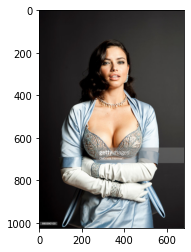

In [21]:
##making sure the right caption, image embeding pair is loaded
im = Image.open(im_path)
plt.imshow(im)
print(tokenizer.sequences_to_texts([token]))
print(emb.shape)

In [22]:
#a faster function that does not return the image path
def load_emb_caption(index, meta_df, embeddings_dir):
    row = meta_df[meta_df.global_index == index]
    emb_path = os.path.join(embeddings_dir, str(index) + '.png' + '.npy' )
    emb = np.load(emb_path)
    token = row.captions_tokenized.tolist()[0]
  
    
    
    
    return emb, token
    

## Batch Loading Training Data
In this section, I have attempted to make use of tensorflows Dataset class to create functions to load our data from memory in batches in parrallel to optimize training time.

In [23]:
def map_load_emb_caption(emb_path, caption):
    """
    Purpose is to speed up and batch process loading resnet_v2 embeddings specifically from the 30k sample
    """
    emb = np.load(emb_path)
    return emb, caption

In [24]:
# add a coliumn in the dataframe that stores the path to the inception_resnet_v2 embedding of the imabsage
data_df['inception_resnet_v2_emb_path'] = data_df['global_index'].apply(lambda x: os.path.join(r'data/30k_sample/inception_v3_embeddings/',str(x) + '.png' +'.npy'))
data_df['inception_resnet_v2_emb_path'].iloc[0]

'data/30k_sample/inception_v3_embeddings/552309.png.npy'

In [25]:
#use our dataframe to create 2 lists: one with image embedding paths and other with respective tokenized and padded captions
image_emb_paths = data_df['inception_resnet_v2_emb_path'].tolist()
padded_tokenized_caps = data_df['captions_tokenized_padded'].tolist()

In [26]:
print(len(image_emb_paths), len(padded_tokenized_caps))

29928 29928


In [27]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
from tensorflow.data import Dataset, AUTOTUNE

In [28]:

def load_dataset(image_emb_paths, padded_tokenized_captions):
    """
    Takes in list of paths to image embeddings and corresponding padded tokenized sequences and loads them into a tensorflow
    Dataset that is batched and uses a buffer size
    """
    dataset = Dataset.from_tensor_slices((image_emb_paths, padded_tokenized_captions))
    dataset = dataset.map(lambda x,y: tf.numpy_function(map_load_emb_caption, [x,y], [tf.float32, tf.int32]),
                         num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset
    
    

## Model

Architecture Parameters:
 - img_emb_dim: number of neurons in FC layer of Encoder that pretrained image embeddings are passed through
 - units: size of RNN hidden layer
 - word_emb_dim: size of word embeddings
 

We will be using a sequence to sequence model that:
<ol>
    <li> ENCODER LAYER </li>
    <ol>
        <li> Takes in pretrained CNN embeddings with dims (64x2048): Since this is taken
        from lower convolutional layers, each of the 64 vectors represents a 'part' of the image
        according to the paper [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf)</li>
        <li> Passes them through an fully connected layer of output dims: (64ximg_emb_dim) </li>
        <li> Applies Relu activation </li>
    </ol>
    <li> ATTENTION LAYER </li>
    <ol>
        <li> Sits inside the decoder model</li>
        <li> Takes in output of encoder model and RNN's previous hidden state </li>
        <li> Passes a concatenation of these into a Dense Layer with tanh activation with output dims:(64xunits)</li>
        <li> Passes the output of the Dense Layer to a single neuron dense layer to get the attention weights for each of the 64 'parts' of the image. Uses softmax to normalize attention weights</li>
        <li> Finally, each of the 64 vectors in the CNN's output are weighted by their respective attention weight to calculate
            a 'context vector' that is the output of the Attention Layer.</li>
    </ol>
    <li> DECODER LAYER: LSTM </li>
    <ol> 
        <li>Takes in a word and a context vector and outputs the next word in the caption (along with a hidden              state) </li>
        <li>Word is first embedded using word2vec</li>
        <li>Then, image features extracted from CNN along with the hidden state (initialized at 0 for <start> token)
            are passed through attention layer to get context vector
        <li> Context vector and word embedding are concatenated and passed through LSTM to get hidden state and output
        <li> Output is passed through 2 fully connected layer, last one with vocab_size neurons
        <li> Word with highest probability is the next word generated
        
        
           
            

In [29]:
from tensorflow.keras.layers import Input,Dense,LSTMCell,Embedding, Reshape, Softmax, RepeatVector, Concatenate, Dot
from tensorflow.keras import Model

In [30]:
NUM_IMG_VEC = 64
IMG_VEC_DIMS = 2048
IMG_EMB_DIM = 256
VOCAB_SIZE = len(tokenizer.word_index) + 1

In [32]:
encoder_model = init_encoder(NUM_IMG_VEC, IMG_VEC_DIMS, IMG_EMB_DIM)

In [33]:
encoder_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 2048)]        0         
_________________________________________________________________
dense (Dense)                (None, 64, 256)           524544    
Total params: 524,544
Trainable params: 524,544
Non-trainable params: 0
_________________________________________________________________


Here, I am using untrainable GloVe embeddings
Other options to experiment with include:
<ol>
    <li> using Word2Vec embeddings
    <li> add a FC layer that is trainable 
    <li> initializing the embedding layer with glove weights but allowing it to be trainable
 </ol>
 All this can be done by simply swapping out this word embedding layer in the model for a different one

In [34]:
import pandas as pd
import csv
GLOVE_DIR = r'Word_Embeddings'
words = pd.read_table(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt'), sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)


In [35]:
#use the tokenizer we built above to get a word index which we will use to build an embedding matrix for GloVe. Code 
#taken from the same source
def build_embeddings_matrix( my_tokenizer, embeddings_index, EMBEDDING_DIM):
    """
    Given a tokenizer created from our training set and 
    EMBEDDING DIM of a particular pretrained embedding model and
    a dictionary of word->embedding of that model, returns an array 
    where each index of the array corresponds to the embedding of the
    word represented by that index
    """
    word_index = my_tokenizer.word_index
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in tqdm(word_index.items()):
        try:
            embedding_vector = embeddings_index.loc[word]    
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
        except KeyError:
            pass
    return embedding_matrix

In [36]:
print(len(tokenizer.word_index))

12942


In [37]:
glove_embedding_matrix = build_embeddings_matrix(tokenizer, words, 300) 

100%|██████████| 12942/12942 [01:06<00:00, 193.58it/s]


In [38]:
## word to GloVE embedding: maybe add FC layer later?
def init_GloVe_word_embedder(GLoVe_emb_dim,glove_embedding_matrix):
    vocab_size = glove_embedding_matrix.shape[0]
    inputs = Input(shape=(1,))
    
    glove_emb = Embedding(vocab_size,
                            GLoVe_emb_dim,
                            weights=[glove_embedding_matrix],
                            trainable=False, input_length=1)(inputs)
    reshaped = Reshape((GLoVe_emb_dim,))(glove_emb)
    #outputs = Dense(GLoVe_emb_dim,word_emb_dim)(reshaped)
    model = Model(inputs = inputs, outputs=reshaped)
    return model

In [39]:
glove_word_embedder = init_GloVe_word_embedder(300, glove_embedding_matrix)

In [40]:
glove_word_embedder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 1, 300)            3882900   
_________________________________________________________________
reshape (Reshape)            (None, 300)               0         
Total params: 3,882,900
Trainable params: 0
Non-trainable params: 3,882,900
_________________________________________________________________


Initialize LSTM model with attention



In [41]:
sizes = {'vocab_size': VOCAB_SIZE,
        'glove_emb_dim': 300,
        'img_emb_dim': 256,
        'img_num_vec': 64,
        'lstm_num_units': 512
        }

In [42]:
def init_attention(sizes):
    enc_output = Input((sizes['img_num_vec'], sizes['img_emb_dim']), name='enc_output')
    prev_hidden =  Input((sizes['lstm_num_units'],),name='prev_hidden')
    
    #repeat hidden so number of dims matches enc_output
    reshaped_hidden = RepeatVector(sizes['img_num_vec'])(prev_hidden)
    
    #concatenate the two inputs
    attention_inp = Concatenate(axis=-1)([enc_output, reshaped_hidden])
    
    #pass through 2 dense layers to calculate attention weights
    attention_dense_1 = Dense(sizes['lstm_num_units']*2, activation = 'tanh')(attention_inp)
    attention_dense_2 = Dense(sizes['lstm_num_units'], activation = 'tanh')(attention_dense_1)
    
    #get attention weights
    attention_weights = Dense(1)(attention_dense_2)
    
    #normalize attention weights
    
    normalized_attention_weights = Softmax(axis=1)(attention_weights)
    
    #calculate context vector by weighting encoder output
    context = Dot(axes = 1)([normalized_attention_weights,enc_output])
    reshaped = Reshape((sizes['img_emb_dim'],))(context)
    
    model = Model(inputs=[enc_output,prev_hidden], outputs=[reshaped, normalized_attention_weights])
    return model

In [43]:
attention_model = init_attention(sizes)

In [44]:
attention_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
prev_hidden (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
enc_output (InputLayer)         [(None, 64, 256)]    0                                            
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 64, 512)      0           prev_hidden[0][0]                
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 64, 768)      0           enc_output[0][0]                 
                                                                 repeat_vector[0][0]        

In [45]:
def init_decoder(sizes, attention_model):
    
    dec_input = Input((sizes['glove_emb_dim'],), name='dec_input')
    hidden_input = Input((sizes['lstm_num_units'],), name='hiden_state')
    attention_context = Input((sizes['img_emb_dim'],), name='attn_context')
    cell_input = Input((sizes['lstm_num_units'],), name = 'cell_state')
    
    LSTM_input = Concatenate(axis=-1)([attention_context, dec_input])
     
    a, state = LSTMCell(sizes['lstm_num_units'])(inputs=LSTM_input, states=[hidden_input,cell_input])
    
    hidden_output = state[0]
    cell_output = state[1]
    
    #pass through fully connected layers
    fc_out_1 = Dense(sizes['lstm_num_units'], activation='relu')(a)
    
    fc_out_2 = Dense(sizes['vocab_size'], activation='softmax')(fc_out_1)
    
    model = Model(inputs=[dec_input,attention_context,hidden_input,cell_input], outputs =[fc_out_2, hidden_output, cell_output])
    
    return model
    
    
    
    
    
    
    
    
    
    
    
    

In [46]:
decoder_model = init_decoder(sizes, attention_model)

In [47]:
decoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attn_context (InputLayer)       [(None, 256)]        0                                            
__________________________________________________________________________________________________
dec_input (InputLayer)          [(None, 300)]        0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 556)          0           attn_context[0][0]               
                                                                 dec_input[0][0]                  
__________________________________________________________________________________________________
hiden_state (InputLayer)        [(None, 512)]        0                                      

In [46]:
decoder_model.get_layer('lstm_cell').output_shape

((None, 512), [(None, 512), (None, 512)])

## Loss and Optimizer:
We are using the adam optimizer with Sparse Categorical Cross entropy loss

In [47]:
##define optimizer and loss function, taken directly from the tensorflow official tutiorial

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    #if real caption is equal to zero (has ended), i.e padded then there is no loss
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [48]:
#training checkpoint manager, also taken from tutorial

In [49]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder_model=encoder_model,
                           glove_word_embedder = glove_word_embedder,
                           attention_model = attention_model,
                           decoder_model=decoder_model,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [50]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [51]:

@tf.function
def train_step(image_emb, target_seq):
    """
    One step of training given 
    image_emb: pretrained embedding of the image 
    target_seq: tokenized and padded caption sentence
    """
    loss = 0
    batch_size = target_seq.shape[0]
    seq_len = target_seq.shape[1]
    lstm_hidden = tf.zeros((batch_size, sizes['lstm_num_units']))
    lstm_cell = tf.zeros((batch_size, sizes['lstm_num_units']))
    
    #first token is always start token.
    word_token = target_seq[:,0]
    
    with tf.GradientTape() as tape:
        image_enc = encoder_model(image_emb)
        #skip start token so we dont feed it in twice
        for word_idx in range(1, seq_len):
            target_word = target_seq[:,word_idx]
            img_context, attn_weights = attention_model([image_enc, lstm_hidden])
            dec_input = glove_word_embedder(word_token)
            dec_output, lstm_hidden, lstm_cell = decoder_model((dec_input, img_context,lstm_hidden,lstm_cell))
            loss += loss_function(target_word, dec_output)
            
            #we are using teacher forcing, so we will be feeding the correct word back into the 
            word_token = target_word
            
        #divide loss by sentence length because we do not want to penalize long sentences
        total_loss = loss/int(seq_len)
        trainable_variables = encoder_model.trainable_variables +  attention_model.trainable_variables + decoder_model.trainable_variables
        
        #gradients of trainable variables wrt to loss
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients,trainable_variables))
        
        return loss, total_loss
        
    
    
    
    

In [52]:
#now, we can finally load the dataset using the pbatched funciton we defined above in section 2
dataset = load_dataset(image_emb_paths,padded_tokenized_caps)
num_steps = len(dataset)

## Train!

In [53]:
EPOCHS = 50
loss_plot = []
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 5 Batch 0 Loss 0.4498
Epoch 5 Batch 100 Loss 0.4266
Epoch 5 Batch 200 Loss 0.4316
Epoch 5 Batch 300 Loss 0.3874
Epoch 5 Batch 400 Loss 0.4234
Epoch 5 Loss 0.404894
Time taken for 1 epoch 339.40 sec

Epoch 6 Batch 0 Loss 0.4610
Epoch 6 Batch 100 Loss 0.3039
Epoch 6 Batch 200 Loss 0.3443
Epoch 6 Batch 300 Loss 0.3555
Epoch 6 Batch 400 Loss 0.3443
Epoch 6 Loss 0.369186
Time taken for 1 epoch 298.83 sec

Epoch 7 Batch 0 Loss 0.3944
Epoch 7 Batch 100 Loss 0.3544
Epoch 7 Batch 200 Loss 0.3114
Epoch 7 Batch 300 Loss 0.4007
Epoch 7 Batch 400 Loss 0.3666
Epoch 7 Loss 0.335829
Time taken for 1 epoch 280.97 sec

Epoch 8 Batch 0 Loss 0.3923
Epoch 8 Batch 100 Loss 0.2800
Epoch 8 Batch 200 Loss 0.2956
Epoch 8 Batch 300 Loss 0.2979
Epoch 8 Batch 400 Loss 0.3575
Epoch 8 Loss 0.303362
Time taken for 1 epoch 311.03 sec

Epoch 9 Batch 0 Loss 0.3638
Epoch 9 Batch 100 Loss 0.2966
Epoch 9 Batch 200 Loss 0.2966
Epoch 9 Batch 300 Loss 0.3256
Epoch 9 Batch 400 Loss 0.2366
Epoch 9 Loss 0.274150
Time taken

KeyboardInterrupt: 

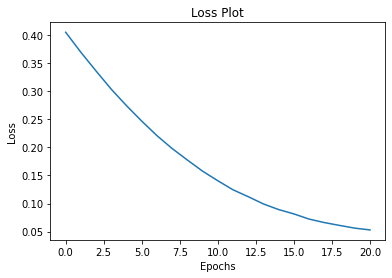

In [54]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Lets see how it does on some captions in the training set
`

In [92]:

import nltk
from nltk.translate.bleu_score import SmoothingFunction
smoothie = SmoothingFunction().method4
def get_bleu(tok_pred, tok_true):
    """
    Given tokenized real and generated captions, returns bleu score
    """
    #remove the end token for pred and both start and end token for true
    tok_pred = tok_pred[:-1]
    tok_true = tok_true[1:]
    tok_true = tok_true[:-1]
    tok_true = [tokenizer.index_word[tok] for tok in tok_true]
    
    return nltk.bleu_score.sentence_bleu([tok_true], tok_pred,smoothing_function=smoothie) 

In [93]:
def caption(image_index, embeddings_dir):
    """
    Captions the image with the given index using image embeddings in the given embeddings directory
    """
    embeddings_path = os.path.join(embeddings_dir, str(image_index) + '.png.npy')
    embedding = np.load(embeddings_path)
    embedding = tf.expand_dims(embedding, 0)
    
    max_len = 50
    lstm_hidden = tf.zeros((1, sizes['lstm_num_units']))
    lstm_cell = tf.zeros((1, sizes['lstm_num_units']))
    #first token is always start token.
    start_index = tokenizer.word_index['<start>']
    word_token = np.full((1,1), start_index, dtype=np.int32)
    
    
    image_enc = encoder_model(embedding)
    
    caption = []
    for i in range(max_len):
    
        img_context, attn_weights = attention_model([image_enc, lstm_hidden])
        dec_input = glove_word_embedder(word_token)
        dec_output, lstm_hidden, lstm_cell = decoder_model((dec_input, img_context,lstm_hidden,lstm_cell))
        
        #sample a word based on the word with max probability improvement: BEAM SEARCH??
        #we tried doing categorical sampling but it was really bad
        word_token = tf.argmax(dec_output, 1)[0].numpy()
        #word_token =tf.random.categorical(dec_output, 1)[0][0].numpy()

        word = tokenizer.index_word[word_token]
        word_token = np.full((1,1), word_token, dtype=np.int32)
        
        caption.append(word)
        
        if(word == '<end>'):
            return caption
        
    return caption
        
    
    
    

In [94]:
### Lets look at some images and then the predicted captions
images_dir = r'data/30k_sample/images'


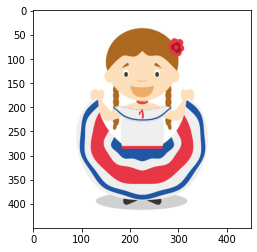

In [95]:
img_index = 1435814
im_path = os.path.join(images_dir, str(img_index) + '.png')
im = Image.open(im_path)
plt.imshow(im)

In [96]:
print("Generated Caption:", caption(img_index, r'data/30k_sample/inception_v3_embeddings/'))
print("Caption Label:", data_df[data_df.global_index == img_index]['caption'].tolist()[0] )

Generated Caption: ['cute', 'elephant', 'holding', 'a', 'blank', 'of', 'a', 'butterfly', '<end>']
Caption Label: character dressed in the traditional way .


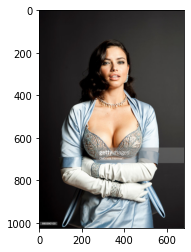

In [97]:
img_index = 790196
im_path = os.path.join(images_dir, str(img_index) + '.png')
im = Image.open(im_path)
plt.imshow(im)

In [98]:
print("Generated Caption:", caption(img_index, r'data/30k_sample/inception_v3_embeddings/'))
print("Caption Label:", data_df[data_df.global_index == img_index]['caption'].tolist()[0] )

Generated Caption: ['portrait', 'of', 'a', 'character', 'holding', 'a', 'moustache', 'and', 'man', 'with', 'strings', 'attached', 'by', 'hands', '<end>']
Caption Label: supermodel is photographed at a portrait shoot .


In [99]:
def display_samples(meta_df, num_samples=5, seed = 0):
    #sample num_sample rows from the dataframe
    samples = meta_df.sample(n=num_samples,random_state = 0)
    for idx,row in samples.iterrows():
        file_name = row['image_path']
        caption = row['caption']
        pred_caption = " ".join(row['pred_captions'])
        
        title_str = f"Actual Caption: {caption}\n Generated Caption: {pred_caption}"
        
        image = Image.open(file_name)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
                         
        plt.xticks([])
        plt.yticks([])
        ax.imshow(image)        
        plt.suptitle(title_str)

        plt.xticks([])
        plt.yticks([])
        plt.show()

In [100]:
train_sample = data_df.sample(100)
train_sample['pred_captions'] = train_sample['global_index'].apply(lambda x: caption(x, r'data/30k_sample/inception_v3_embeddings/'))


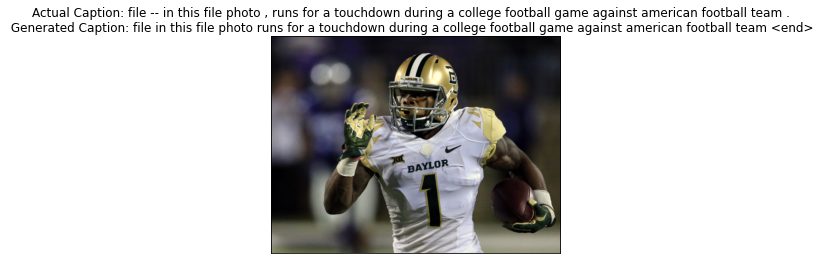

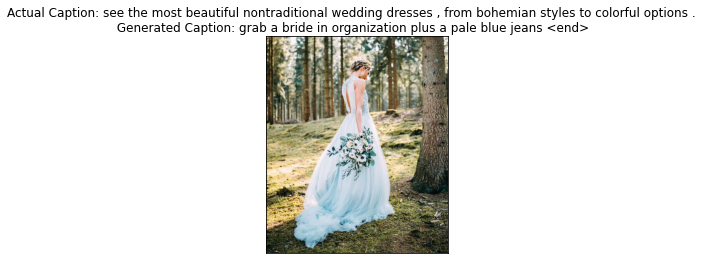

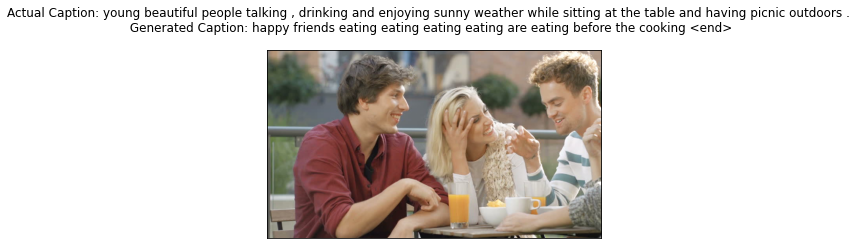

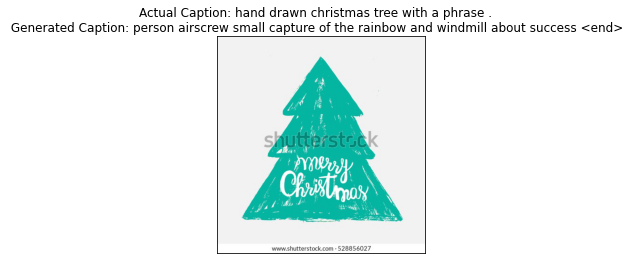

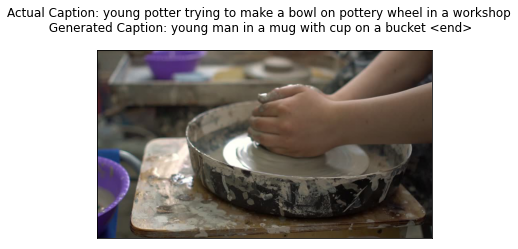

In [101]:
display_samples(train_sample)

In [103]:
train_sample['bleu_scores'] = train_sample.apply(lambda x: get_bleu( x.pred_captions, x.captions_tokenized), axis = 1)

In [104]:
train_sample['bleu_scores'].describe()

count    100.000000
mean       0.437318
std        0.311087
min        0.000000
25%        0.240206
50%        0.375681
75%        0.573459
max        1.000000
Name: bleu_scores, dtype: float64

## Evaluation

### Evaluation methodology: Bleu score

In [105]:
import nltk
from nltk.translate.bleu_score import SmoothingFunction
smoothie = SmoothingFunction().method4

In [106]:
def get_bleu(tok_pred, tok_true):
    """
    Given tokenized real and generated captions, returns bleu score
    """
    #remove the end token for pred and both start and end token for true
    tok_pred = tok_pred[:-1]
    tok_true = tok_true[1:]
    tok_true = tok_true[:-1]
    tok_true = [tokenizer.index_word[tok] for tok in tok_true]
    
    return nltk.bleu_score.sentence_bleu([tok_true], tok_pred,smoothing_function=smoothie) 

### Loading test set

In [107]:
test_df = pd.read_csv('data/initial_sample/sent_added')

In [108]:
def process_test_caption(tokenizer, data_df, max_len=50):
    """
    Preprocess the captions on the test set using our existing tokenizer:
    """
    data_df['captions_processed'] = data_df['caption'].apply(lambda x: '<start> ' + x + ' <end>')
    data_df['captions_tokenized'] = tokenizer.texts_to_sequences(data_df['captions_processed'])
    list_of_tokenized_captions = data_df['captions_tokenized'].tolist()
    padded_tok_captions = tf.keras.preprocessing.sequence.pad_sequences(list_of_tokenized_captions, padding='post', maxlen=50)
    padded_tok_captions = padded_tok_captions.tolist()
    data_df['captions_tokenized_padded'] = pd.Series(padded_tok_captions)
    return data_df


In [115]:
#sample a random set of 5000 image caption pairs to evaluate on
test_sample = test_df.sample(100)
test_sample = process_test_caption(tokenizer, test_sample)

In [116]:
test_sample['pred_captions'] = test_sample['global_index'].apply(lambda x: caption(x, r'data/initial_sample/inception_v3_embeddings/'))


### Moment of truth on test data fingers crossed!

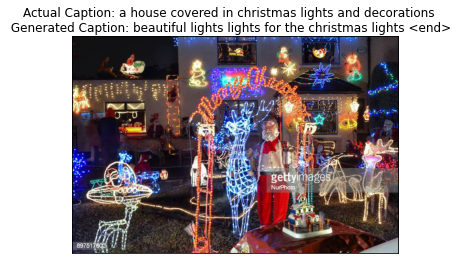

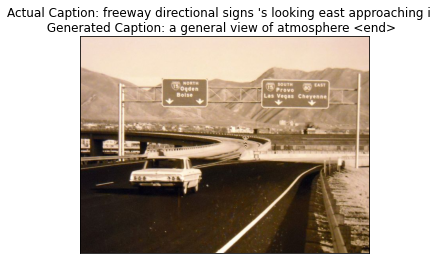

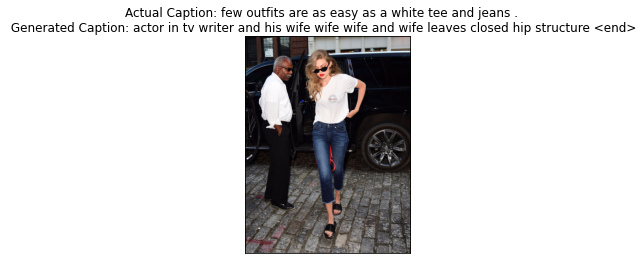

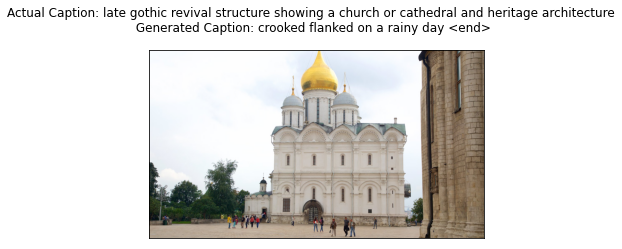

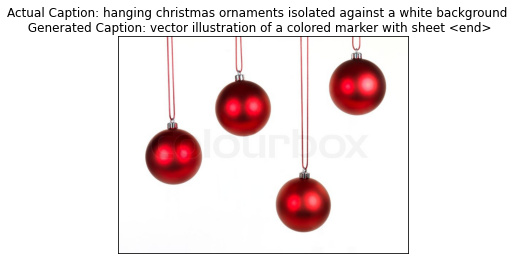

In [117]:
display_samples(test_sample)

In [112]:
test_sample['bleu_scores'] = test_sample.apply(lambda x: get_bleu( x.pred_captions, x.captions_tokenized), axis = 1)

In [113]:
test_sample['bleu_scores'].describe()

count    100.000000
mean       0.248761
std        0.244595
min        0.000000
25%        0.000000
50%        0.243478
75%        0.398001
max        1.000000
Name: bleu_scores, dtype: float64